In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression

pd.set_option('display.max_rows', None)


# 0. Functions

In [804]:
def predict(X, y, model='window', recession=False):
    """
    This function is used to make the predictions. The parameters help set up the details of the model to be used.
    model: either takes value window or accumulate. If window, it means we use the previous 17 data point from the
    one we want to predict to create the model. If accumulate, we take all data points preceding the one we want
    to predict.
    recession: If false it means we are working on the whole data set. If true we are strinctly working on the days
    corresponding to the recession.
    """
    
    if model=='window' and not recession:
    
        k = 17
        y_tests = []
        y_hats = []
        
        # special case to begin when we still don't have 17 data points yet
        # starting at date 2005-06-01 (which is the 5th data point in the data set) we will use every past data 
        # points in the training set up until the 17th data point
        
        for i in np.arange(5, 17, 1):

            X_train = X[:i,:]
            X_test = X[i,:]

            y_train = y[:i]
            y_test = y[i]

            reg = LinearRegression()
            reg.fit(X_train, y_train)

            #X_test.reshape(1,X.shape[1])
            y_hat = reg.predict([X_test])
            y_tests.append(y_test)
            y_hats.append(y_hat)
            
        
        # now we do the second loop where we only use a window of 17 elements to train
        
        i = 0
        
        while i+17<X.shape[0]:

            X_train = X[i:i+k,:]
            X_test = X[i+k,:]
            y_train = y[i:i+k]
            y_test = y[i+k]

            reg = LinearRegression()
            reg.fit(X_train, y_train)

            y_hat = reg.predict([X_test])

            y_tests.append(y_test)
            y_hats.append(y_hat)

            i+=1
        y_hats = [el[0] for el in y_hats]
        return y_tests, y_hats
    
    elif model=='accumulate' and not recession:
        
        k = 17
        y_tests = []
        y_hats = []

        # Use all previous data points to train

        for i in np.arange(5, X.shape[0], 1):

            X_train = X[:i,:]
            X_test = X[i,:]

            y_train = y[:i]
            y_test = y[i]

            reg = LinearRegression()
            reg.fit(X_train, y_train)

            #X_test.reshape(1,X.shape[1])
            y_hat = reg.predict([X_test])
            y_tests.append(y_test)
            y_hats.append(y_hat)
       
        y_hats = [el[0] for el in y_hats]
        return y_tests, y_hats

    elif model=='accumulate' and recession:
        y_tests = []
        y_hats = []
        
        # Use all previous data points to train
        # We have detected that the data points corresponding to dates during the recession are 
        # data points 47 to 65
        # -12 because we have deleted the first 12 data points from X as feature y_{t-12} does not exist


        for i in np.arange(47-12, 66-12, 1):

            X_train = X[:i,:]
            X_test = X[i,:]

            y_train = y[:i]
            y_test = y[i]

            reg = LinearRegression()
            reg.fit(X_train, y_train)

            y_hat = reg.predict([X_test])
            y_tests.append(y_test)
            y_hats.append(y_hat)

        y_hats = [el[0] for el in y_hats]
        return y_tests, y_hats

    elif model=='window' and recession:
        y_tests = []
        y_hats = []

        # Use the 17 previous data points to train
        # We have detected that the data points corresponding to dates during the recession are 
        # data points 47 to 65
        # -12 because we have deleted the first 12 data points from X as feature y_{t-12} does not exist
        
        for i in np.arange(47-12, 66-12, 1):

            X_train = X[i-17:i,:]
            X_test = X[i,:]

            y_train = y[i-17:i]
            y_test = y[i]

            reg = LinearRegression()
            reg.fit(X_train, y_train)

            #X_test.reshape(1,X.shape[1])
            y_hat = reg.predict([X_test])
            y_tests.append(y_test)
            y_hats.append(y_hat)

        y_hats = [el[0] for el in y_hats]
        return y_tests, y_hats
    
    else:
        print('Error: No model has been detected')
        return -1
    
def plot_fig(y_tests, y_tests_rec, y_hats,y_hats_trends, y_hats_rec, y_hats_trends_rec, model):
    """
    Function to plot the predictions for the model with and without trends versus real data
    y_tests: real value
    y_tests: real value from data points during recession
    y_hats: predicted values
    y_hats_trends: predicted values using trends in model
    y_hats_rec: predicted values from data points during recession
    y_hats_trends_rec: predicted values from data points during recession using trends in model
    model: specify which model we use: 17 days window training, or using all previous days
    
    
    """
    fig, ax = plt.subplots(figsize=(10,5))

    ax.plot(data.index[-len(y_tests):], y_tests, linestyle='solid', label='Actual')
    ax.plot(data.index[-len(y_tests):], y_hats, linestyle='dashed', label='Base')
    ax.plot(data.index[-len(y_tests):], y_hats_trends, linestyle='solid', label='Trends')
    ax.legend(['Actual', 'Base', 'Trends'],loc='upper right')
    ax.set_title('Motor Vehicles and Parts')
    ax.set_xlabel("Index")
    ax.set_ylabel("log(mvp)")

    # this if statement helps adjust the box around the text in the plot
    if model == 'window':
        ax.axhline(y=10.85, xmin=0, xmax=0.43, color='grey')
    elif model == 'accumulate':
        ax.axhline(y=10.895, xmin=0, xmax=0.43, color='grey')

    ax.axvline(x='2008-01-01', ymin=0, ymax=0.284, color='grey')
    # improvement between not using trends and using trends
    
    mae_base = sklearn.metrics.mean_absolute_error(y_tests, y_hats)*100
    mae_trends = sklearn.metrics.mean_absolute_error(y_tests, y_hats_trends)*100
    pct = np.abs(mae_base-mae_trends)/max(mae_base, mae_trends)*100
    
    # improvement between not using trends and using trends during recession only
    
    mae_base_rec = sklearn.metrics.mean_absolute_error(y_tests_rec, y_hats_rec)*100
    mae_trends_rec = sklearn.metrics.mean_absolute_error(y_tests_rec, y_hats_trends_rec)*100
    pct_rec = np.abs(mae_base_rec-mae_trends_rec)/max(mae_base_rec, mae_trends_rec)*100
    

    textstr = '\n'.join((
        'MAE improvement',
        'Overall = {:.2f} %'.format(pct),
        'During recession = {:.2f} %'.format(pct_rec)))

    start = pd.to_datetime('2007-12-01')
    end = pd.to_datetime('2009-06-01')

    ax.text(0.05, 0.05, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='bottom')
    
    return mae_base, mae_trends, mae_base_rec, mae_trends_rec



# 1. Data Cleaning

- Data is already sampled by month
- Set the Period column to become the new index
- Transform data to log data
- Generate new features $y_{t-1}$ and $y_{t-12}$
- Delete NaN data

In [805]:
data = pd.read_csv('merged_autos.csv')
data['Period'] = pd.to_datetime(data['Period'])
data = data.set_index('Period')
data['log_sales'] = np.log(data['sales'])

In [806]:
data['y(t-1)'] = pd.DataFrame(data['log_sales']).T.shift(periods=1, axis=1).T
data['y(t-12)'] = pd.DataFrame(data['log_sales']).T.shift(periods=12, axis=1).T

In [807]:
data.head(15)

,sales,suvs,insurance,log_sales,y(t-1),y(t-12)
Period,,,,,,
2004-01-01,61287,0.00,0.00,11.023323,NaN,NaN
2004-02-01,65381,-0.12,-0.01,11.087987,11.023323,NaN
2004-03-01,78843,-0.05,-0.09,11.275214,11.087987,NaN
2004-04-01,73422,-0.12,-0.08,11.203979,11.275214,NaN
2004-05-01,77662,-0.07,-0.07,11.260121,11.203979,NaN
2004-06-01,75516,-0.12,0.01,11.232100,11.260121,NaN
2004-07-01,78991,-0.14,0.07,11.277089,11.232100,NaN
2004-08-01,76521,-0.09,0.05,11.245320,11.277089,NaN
2004-09-01,73711,-0.12,-0.07,11.207907,11.245320,NaN


We don't use the first twelve data points seeing we can't use the column `y(t-12)` in the training set

In [808]:
data = data.iloc[12:,:]

We create two sets of data: one where we do not take the trends as input in the model and one where we do use this as a variable in our AR-1 model.

In [809]:
y = data['log_sales'].values

X = data[['y(t-1)', 'y(t-12)']].values

X_trends = data[['suvs', 'insurance','y(t-1)', 'y(t-12)']].values

First, we fit the overall data to find the coefficients in order to compare what we have with the data from the paper.

In [810]:
reg = LinearRegression()
reg_trends = LinearRegression()

reg.fit(X,y)
reg_trends.fit(X_trends, y)

LinearRegression()

In [811]:
'When we fit the whole dataset we obtain an intercept of {:.5f} and coefficients {:.5f} and {:.5f} for our AR-1 model. These values coincide with the parameters described in the paper.'.format(reg.intercept_, reg.coef_[0], reg.coef_[1])

'When we fit the whole dataset we obtain an intercept of 0.67266 and coefficients 0.64345 and 0.29565 for our AR-1 model. These values coincide with the parameters described in the paper.'

In [812]:
'When we fit the whole dataset we obtain an intercept of {:.5f} and coefficients {:.5f}, {:.5f}, {:.5f} and {:.5f} for our AR-1 model. These value coincide with the parameters described in the paper.'.format(reg_trends.intercept_, reg_trends.coef_[0], reg_trends.coef_[1], reg_trends.coef_[2], reg_trends.coef_[3])




'When we fit the whole dataset we obtain an intercept of -0.45798 and coefficients 1.05721, -0.52966, 0.61947 and 0.42865 for our AR-1 model. These value coincide with the parameters described in the paper.'

# 2. Predictions

Before creating a model, we had to make sure we understood the process described in the paper. We knew that we would use a Linear Regression as the results from the two previous cells show that we obtain the same coefficients as in the paper (See under section 'IV Examples' from the paper, the Table with the coefficients). From the paper, there were in my opinion two different ways to understand the modelization:
- To predict any day, we use the past 17 days in the training process
- To predict any day, we use all previous data points in the training process. We start our predictions for the 17th day of the data set.

In this section, we will then apply the two models (the function can be seen in part `0. Functions`) and compare their performances.

### First model: use a 17 days window to train and then predict

Next, we will train on a window of days $k=17$ to fit the parameters and then predict the next value. We use $y_{t-1}$ to $y_{t-17}$ to train a model and then predict value $y_{t}$. We make the predictions for $y$ using 
- `X` the matrix containing the basic features, and
- `X_trends` the matrix containing the basic features and the Google trends

Our plot allows to compare both predictions

In [813]:
y_tests, y_hats = predict(X, y, model='window', recession=False)
y_tests, y_hats_trends = predict(X_trends, y, model='window', recession=False)

# recession data
y_tests_rec, y_hats_rec = predict(X, y, model='window', recession=True)
y_tests_rec, y_hats_trends_rec = predict(X_trends, y, model='window', recession=True)

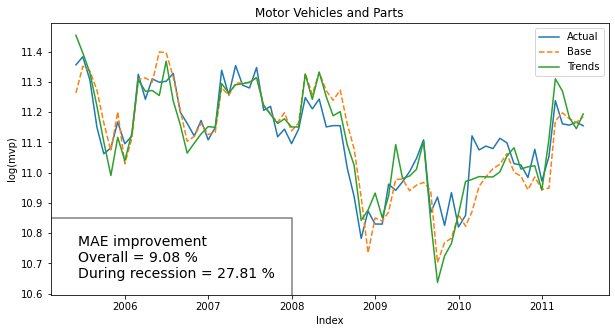

In [814]:
mae_base, mae_trends, mae_base_rec, mae_trends_rec = plot_fig(y_tests, y_tests_rec, y_hats, y_hats_trends, y_hats_rec, y_hats_trends_rec, model='window')

In [815]:
'We have an MAE of {:.2f} using the baseline model and an MAE of {:.2f} using  the trends data'.format(mae_base, mae_trends)

'We have an MAE of 6.20 using the baseline model and an MAE of 5.64 using  the trends data'

In [816]:
'During the recession, we have an MAE of {:.2f} using the baseline model and an MAE of {:.2f} using  the trends data'.format(mae_base_rec, mae_trends_rec)


'During the recession, we have an MAE of 7.71 using the baseline model and an MAE of 5.56 using  the trends data'

### Second model: using all past data points to train

In this model, we start predicting at data point $k=17$, but this time each data point is predicted using all past data points in the training process.

In [817]:
y_tests, y_hats = predict(X,y, model='accumulate', recession=False)
y_tests, y_hats_trends = predict(X_trends, y, model='accumulate', recession=False)

y_tests_rec, y_hats_rec = predict(X, y, model='accumulate', recession=True)
y_tests_rec, y_hats_trends_rec = predict(X_trends, y, model='accumulate', recession=True)

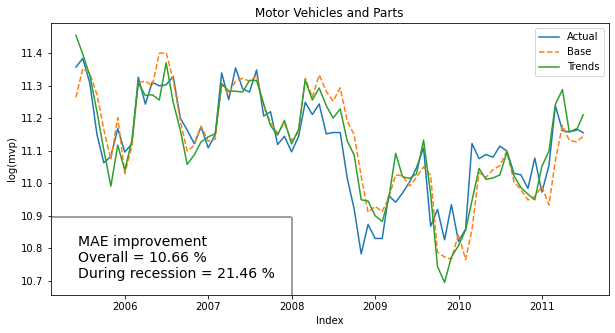

In [818]:
mae_base, mae_trends, mae_base_rec, mae_trends_rec = plot_fig(y_tests,y_tests_rec, y_hats, y_hats_trends, y_hats_rec, y_hats_trends_rec, model='accumulate')

In [819]:
'We have an MAE of {:.2f} using the baseline model and an MAE of {:.2f} using  the trends data'.format(mae_base, mae_trends)

'We have an MAE of 6.34 using the baseline model and an MAE of 5.67 using  the trends data'

In [820]:
'During the recession, we have an MAE of {:.2f} using the baseline model and an MAE of {:.2f} using  the trends data'.format(mae_rec_base, mae_rec_trends)

'During the recession, we have an MAE of 7.17 using the baseline model and an MAE of 6.24 using  the trends data'

As a last comment, we see that overall the first model (the one that takes the past 17 data points to train the model and predict one data point) performs better as the MAE error is minimized. The first model gives us sn MAE 5.64 using Google trends data, while the second model 5.67.

From the MAE results, we can see that **the second model is the one that has been implemented for the publication of the paper**. From the look of our results, we can consider our work to be closely representative to the results displayed in the paper.